In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, done, _, info = self.env.step(action)

        #一局游戏最多走N步
        self.step_n += 1
        if self.step_n >= 200:
            done = True

        return state, reward, done, info


env = MyWrapper()

env.reset()

array([-0.9459288 , -0.32437435,  0.73634136], dtype=float32)

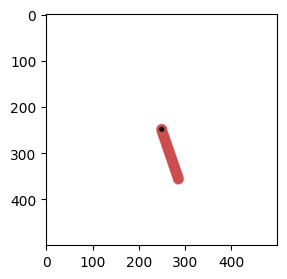

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.figure(figsize=(3, 3))
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
#认识游戏环境
def test_env():
    print('env.observation_space=', env.observation_space)
    print('env.action_space=', env.action_space)

    state = env.reset()
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    print('state=', state)
    print('action=', action)
    print('next_state=', next_state)
    print('reward=', reward)
    print('done=', done)


test_env()

env.observation_space= Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
env.action_space= Box(-2.0, 2.0, (1,), float32)
state= [-0.966843    0.25537148 -0.4515908 ]
action= [0.48694044]
next_state= [-0.9644128   0.2644012  -0.18702114]
reward= -8.33439976337045
done= False


In [4]:
import torch

#计算动作的模型,也是真正要用的模型
model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

#经验网络,用于评估一个状态的分数
next_model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

#把model的参数复制给next_model
next_model.load_state_dict(model.state_dict())

model, next_model

(Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ))

In [5]:
import random


def get_action(state):
    #走神经网络,得到一个动作
    state = torch.FloatTensor(state).reshape(1, 3)
    action = model(state).argmax().item()

    if random.random() < 0.01:
        action = random.choice(range(11))

    #离散动作连续化
    action_continuous = action
    action_continuous /= 10
    action_continuous *= 4
    action_continuous -= 2

    return action, action_continuous


get_action([0.29292667, 0.9561349, 1.0957013])

(8, 1.2000000000000002)

In [6]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action, action_continuous = get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step([action_continuous])

            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 5000:
        datas.pop(0)


update_data()

len(datas)

200

In [7]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state, action, reward, next_state, over

/tmp/ipykernel_41896/1416897299.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)


(tensor([[ 5.8002e-01, -8.1460e-01, -4.8659e+00],
         [ 4.2210e-01, -9.0655e-01, -9.3213e-01],
         [-7.9495e-01, -6.0667e-01, -4.9727e+00],
         [ 9.9486e-01,  1.0124e-01, -5.8302e+00],
         [ 2.9155e-01,  9.5656e-01, -6.6488e+00],
         [-3.6837e-01,  9.2968e-01, -7.2113e+00],
         [ 9.6127e-01, -2.7561e-01, -3.4661e+00],
         [ 3.4939e-01, -9.3698e-01, -5.2368e+00],
         [-9.3281e-01, -3.6038e-01, -8.0000e+00],
         [ 9.7827e-01, -2.0733e-01, -6.0045e+00],
         [ 8.6188e-01, -5.0712e-01, -6.4600e+00],
         [-3.8155e-01,  9.2435e-01, -7.4915e+00],
         [ 9.7981e-01, -1.9994e-01, -6.0542e+00],
         [-9.9146e-01, -1.3039e-01, -5.2345e+00],
         [-9.6150e-01, -2.7482e-01, -7.2963e+00],
         [-4.0645e-01, -9.1367e-01,  4.9823e+00],
         [-9.3281e-01, -3.6038e-01, -8.0000e+00],
         [-2.9172e-01,  9.5650e-01, -5.2620e+00],
         [ 9.7827e-01, -2.0732e-01, -6.0045e+00],
         [ 7.8532e-01,  6.1909e-01, -5.9155e+00],


In [8]:
def get_value(state, action):
    #使用状态计算出动作的logits
    #[b, 3] -> [b, 11]
    value = model(state)

    #根据实际使用的action取出每一个值
    #这个值就是模型评估的在该状态下,执行动作的分数
    #在执行动作前,显然并不知道会得到的反馈和next_state
    #所以这里不能也不需要考虑next_state和reward
    #[b, 11] -> [b, 1]
    value = value.gather(dim=1, index=action)

    return value


get_value(state, action)

tensor([[0.5589],
        [0.1906],
        [0.7206],
        [0.5936],
        [0.8485],
        [0.9757],
        [0.3763],
        [0.6412],
        [1.1037],
        [0.5958],
        [0.6672],
        [1.0034],
        [0.6005],
        [0.7048],
        [1.0028],
        [0.9286],
        [1.1037],
        [0.7828],
        [0.5958],
        [0.6724],
        [0.5879],
        [0.7576],
        [0.9325],
        [0.9010],
        [0.5726],
        [0.8559],
        [0.9686],
        [1.0380],
        [1.0372],
        [1.0472],
        [0.5861],
        [0.4862],
        [0.9325],
        [1.0386],
        [0.6829],
        [0.6667],
        [0.6113],
        [1.0915],
        [1.1034],
        [0.3418],
        [0.4100],
        [0.6672],
        [0.7535],
        [0.6672],
        [1.0386],
        [0.7545],
        [0.6113],
        [1.0131],
        [1.1096],
        [0.5035],
        [0.8513],
        [0.9683],
        [0.6113],
        [1.0366],
        [0.6724],
        [0

In [9]:
def get_target(reward, next_state, over):
    #上面已经把模型认为的状态下执行动作的分数给评估出来了
    #下面使用next_state和reward计算真实的分数
    #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    #使用next_state计算下一个状态的分数
    #[b, 3] -> [b, 11]
    with torch.no_grad():
        target = next_model(next_state)

    #取所有动作中分数最大的
    #[b, 11] -> [b, 1]
    target = target.max(dim=1)[0]
    target = target.reshape(-1, 1)

    #下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    #如果next_state已经游戏结束,则next_state的分数是0
    #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    #[b, 1] * [b, 1] -> [b, 1]
    target *= (1 - over)

    #加上reward就是最终的分数
    #[b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_target(reward, next_state, over)

tensor([[ -2.6482],
        [ -1.1666],
        [ -7.9569],
        [ -2.8249],
        [ -5.3108],
        [ -8.1130],
        [ -0.8815],
        [ -3.4968],
        [-13.0738],
        [ -2.9991],
        [ -4.4585],
        [ -8.5528],
        [ -3.0521],
        [-11.0352],
        [-12.5834],
        [ -5.6039],
        [-13.0738],
        [ -5.5549],
        [ -2.9992],
        [ -3.3498],
        [ -2.7612],
        [ -4.3113],
        [ -6.7945],
        [ -6.2122],
        [ -2.5241],
        [ -5.3614],
        [ -6.8851],
        [-15.0442],
        [-12.3906],
        [-15.1909],
        [ -5.1421],
        [ -2.0895],
        [ -6.7945],
        [-15.0599],
        [ -3.4546],
        [ -2.4686],
        [ -2.8800],
        [ -9.0327],
        [-13.0885],
        [ -0.4519],
        [ -1.3342],
        [ -3.7201],
        [ -4.2673],
        [ -3.7201],
        [-15.0599],
        [ -4.1560],
        [ -2.8799],
        [ -8.7902],
        [-10.5367],
        [ -4.0360],


In [10]:
from IPython import display


def test(play=False):
    state = env.reset()
    reward_sum = 0
    over = False
    while not over:
        _, action_continuous = get_action(state)
        state, reward, over, _ = env.step([action_continuous])
        reward_sum += reward

        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


sum([test() for _ in range(20)]) / 20

-1394.3801358473431

In [11]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            #更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #把model的参数复制给next_model
            if (i + 1) % 50 == 0:
                next_model.load_state_dict(model.state_dict())

        if epoch % 20 == 0:
            print(epoch, len(datas), sum([test() for _ in range(5)]) / 5)

    torch.save(model, 'save/5.DQN_Pendulum')


#train()

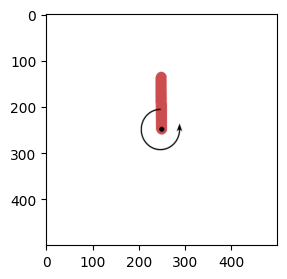

-356.57743230826736

In [13]:
model = torch.load('save/5.DQN_Pendulum')

test(play=True)